# Perceptual decision-making and Psychophysics

如何用最大似然估计(maximum likelihood estimation, MLE)的方法估计weibull心理物理曲线的阈值

## Weibull psychometric function
Weibull函数为
$$
    y = 1 - (1-\gamma)\exp^{-(\frac{k*x}{\alpha})^\beta}
$$
其中
$$
k=-log(\frac{1-g}{1-\gamma})^{\frac{1}{\beta}}
$$


* $\alpha$为该正确率下的threshold
* $\beta$为函数的slope
* $\gamma$为基线chance level的概率值(这里我们固定为0.5)
* * $g$ 为threshold对应的正确率(这里我们固定为0.82)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 先定义weibull函数
def weibullfun(x, alpha, beta, gamma, g):
    k = (-np.log((1-g)/(1-gamma)))**(1/beta)
    y = 1 - (1 - gamma)*np.exp(-(k*x/alpha) ** beta) # hack here to avoid the complex number of 
    return y

Text(0, 0.5, 'Prob of correct')

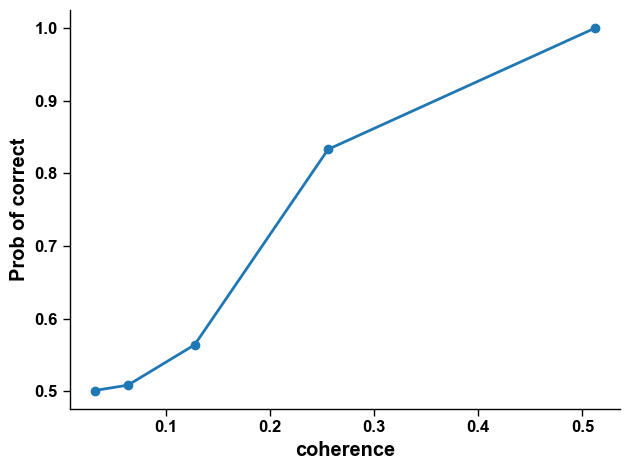

In [2]:
from scipy.stats import bernoulli
coh = np.array([0.032, 0.064, 0.128, 0.256, 0.512]) # coherence level in literature

# 定义参数
g = 0.82
gamma = 0.5 # Baseline chance level
beta = 3. # slop steepness
alpha = 0.25 # coherence threshold corresponding to g

nTrialPerCoh = 1000 # how many trials per coh level

pCoh = weibullfun(coh, alpha, beta, gamma, g)

plt.plot(coh, pCoh, 'o-')
plt.xlabel('coherence')
plt.ylabel('Prob of correct')

In [3]:
data = np.empty((coh.size, nTrialPerCoh))
for iCoh in range(coh.size): # loop coherence level
    # use bernouli process to generate data
    data[iCoh, :] = bernoulli.rvs(pCoh[iCoh], size=nTrialPerCoh)

cohTrial = np.tile(coh[:, np.newaxis], (1, nTrialPerCoh)).flatten() #(5000, ) array
data = data.flatten() # (5000, ) array

print(cohTrial)
print(cohTrial.size)
print(data)
print(data.size)

[0.032 0.032 0.032 ... 0.512 0.512 0.512]
5000
[1. 1. 1. ... 1. 1. 1.]
5000


* `cohTrial`是一个长度nTrialPerCoh x 5的数组，代表每个trial的coherence level
* `data`是一个长度nTrialPerCoh x 5的数组，代表每个trial被试做对(1)和做错(0)

下面我们写出负对数似然函数
这里我们只假定threshold $\alpha$是需要估计的自由参数

In [4]:
eps = np.finfo(float).eps
def loglikeli(alpha): # note that this is not negative log likeli
    g = 0.82
    beta = 3
    gamma = 0.5

    prob = np.zeros(cohTrial.size)
    
    prob = weibullfun(cohTrial, alpha, beta, gamma, g)
    prob = prob*data + (1-prob)*(1-data)
    prob = prob * 0.999 + eps
   
    return np.log(prob).sum()

In [5]:
samplesize = 500 # 从q(x)里面取多少
from scipy.stats import norm,uniform
eps = np.finfo(float).eps

def lossfun(params):
    # 
    u = params[0] # q高斯函数的均值
    sigma = params[1] # q高斯函数的std
    
    # deal with variational distribution
    ss = norm.rvs(loc=u, scale=sigma, size=samplesize) # ss是(-inf, inf) # 从q分布中采500个样本
    
    llq = np.log(norm.pdf(ss, loc=u, scale=sigma)*0.999 + eps) # 计算这些样本在q分布的loglikeli
    
    # deal with generative model
    ss = 1./(1+np.exp(-ss)) # 样本transform to (0,1), 因为阈限是(0,1)以内 

    llp = [loglikeli(s) for s in ss] # 求这些log(p(data|alpha))
    llp = np.array(llp) # 对于所有的ss，计算针对data的likelihood
    
    llprior = np.log(uniform.pdf(ss,loc=0, scale=1)*0.999+eps) # log(p(alpha))

    dd = llq-llp - llprior # 构建优化目标
    
    return dd.sum()/samplesize/cohTrial.size # 我们再除以trial数量，以保证返回数量不会太大

下面来优化这个负对数似然函数

In [6]:
from scipy.optimize import minimize

res = minimize(fun=lossfun, x0=(0, 1), method='Powell', bounds=((-5, 0), (eps, 5))) 

In [7]:
print('The estimated parameters is', res.x)
# Gaussian distribution的均值转化成(0,1)的阈限为
print('The mean of threshold is', 1./(1+np.exp(-res.x[0])))

The estimated parameters is [-1.0848973   0.02625092]
The mean of threshold is 0.25258036744019224


Text(0, 0.5, 'q(x)=p(x|data)')

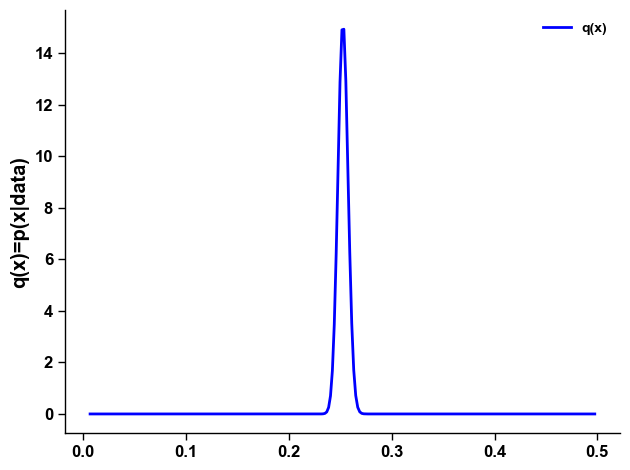

In [8]:
# 完成之后, 我们画出分布
x = np.arange(-5., 0., 0.01)
xx = 1/(1+np.exp(-x))
plt.plot(xx, norm.pdf(x, loc=res.x[0], scale=res.x[1]), color='b', label='q(x)')
plt.legend()
plt.ylabel('q(x)=p(x|data)')